# Filter input k-mers based on the number of cells presenting that k-mer

# Imports

In [85]:
import glob
import os
import re
import shutil

import numpy as np
import pandas as pd
import scanpy as sc
import sig_utils
from joblib import Parallel, delayed
import seaborn as sns
from tqdm import tqdm

import sig_reorg

pd.options.display.max_rows = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Def Describe

In [2]:
%%file pandas_utils.py

def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

Overwriting pandas_utils.py


In [3]:
from pandas_utils import describe

## Read one2one h5ad

In [4]:
adata = sc.read(
#     "/home/phoenix/data_lg/data_sm_copy/code/immune-evolution/h5ads/human-lemur-mouse-bat__lung_only_copy.h5ad"
    "/home/olga/data_lg/data_sm_copy/immune-evolution/h5ads/human-lemur-mouse-bat/human-lemur-mouse-bat__lung_only.h5ad"
)
adata.obs = adata.obs.reset_index().set_index('cell_id')
print(adata)
adata.obs.head()

AnnData object with n_obs × n_vars = 126745 × 10560
    obs: 'index', 'age', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'free_annotation', 'individual', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'tissue', 'narrow_group', 'broad_group', 'compartment_group', 'compartment_narrow', 'channel_cleaned', 'batch', 'n_genes', 'n_counts', 'species_batch_v2', 'compartment_broad', 'compartment_broad_narrow', 'compartment_species', 'compartment_narrow_species', 'common_individual_id'
    var: 'bat__gene_name', 'mouse_lemur__gene_name-bat', 'mouse__gene_name-bat', 'mouse_lemur__gene_name_x-hlm', 'mouse__gene_name_x-hlm', 'gene_ids-lemur-hlm', 'n_cells-mouse-hlm', 'mouse_lemur__gene_name_y-hlm', 'mouse__gene_name_y-hlm'


,index,age,cell_barcode,cell_ontology_class,cell_ontology_id,channel,free_annotation,individual,sample,sequencing_run,...,channel_cleaned,batch,n_genes,n_counts,species_batch_v2,compartment_broad,compartment_broad_narrow,compartment_species,compartment_narrow_species,common_individual_id
cell_id,,,,,,,,,,,,,,,,,,,,,
P2_1__AAACCTGAGAAACCAT,P2_1_AAACCTGAGAAACCAT-human-hlm,46y,AAACCTGAGAAACCAT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AAATGCCAGATGAGAG,P2_1_AAATGCCAGATGAGAG-human-hlm,46y,AAATGCCAGATGAGAG,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGATCCCT,P2_1_AACACGTTCGATCCCT-human-hlm,46y,AACACGTTCGATCCCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGCACTCT,P2_1_AACACGTTCGCACTCT-human-hlm,46y,AACACGTTCGCACTCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACCATGCAGCTCGCA,P2_1_AACCATGCAGCTCGCA-human-hlm,46y,AACCATGCAGCTCGCA,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2


In [5]:
adata.obs.species.value_counts()

Human          57353
Mouse lemur    36934
Mouse          23802
Bat             8656
Name: species, dtype: int64

In [6]:
adata.obs.query('species == "Mouse"').groupby(["age", "channel"], observed=True).size()

age  channel           
18m  MACA_18m_F_LUNG_50     320
     MACA_18m_F_LUNG_51    1138
     MACA_18m_M_LUNG_52    1573
     MACA_18m_M_LUNG_53    1256
21m  MACA_21m_F_LUNG_54    1312
     MACA_21m_F_LUNG_55    1526
30m  10X_P1_6              7728
     10X_P1_14             1565
     10X_P2_5               920
     10X_P3_0               496
1m   10X_P5_13             1043
     10X_P5_14             1384
3m   10X_P7_8               348
     10X_P7_9               979
     10X_P8_12              578
     10X_P8_13             1636
dtype: int64

## Set shared celltypes

In [7]:
SHARED_CELLTYPES = ['Alveolar Epithelial Type 2',
 'B cell',
 'Capillary',
 'Dendritic',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'Natural Killer T cell',
 'Smooth Muscle and Myofibroblast',
 'T cell']
len(SHARED_CELLTYPES)

10

In [8]:
adata_shared = adata[adata.obs.broad_group.isin(SHARED_CELLTYPES)]
adata_shared

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 89795 × 10560
    obs: 'index', 'age', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'free_annotation', 'individual', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'tissue', 'narrow_group', 'broad_group', 'compartment_group', 'compartment_narrow', 'channel_cleaned', 'batch', 'n_genes', 'n_counts', 'species_batch_v2', 'compartment_broad', 'compartment_broad_narrow', 'compartment_species', 'compartment_narrow_species', 'common_individual_id'
    var: 'bat__gene_name', 'mouse_lemur__gene_name-bat', 'mouse__gene_name-bat', 'mouse_lemur__gene_name_x-hlm', 'mouse__gene_name_x-hlm', 'gene_ids-lemur-hlm', 'n_cells-mouse-hlm', 'mouse_lemur__gene_name_y-hlm', 'mouse__gene_name_y-hlm'

In [9]:
CELL_IDS_TO_USE = set(adata_shared.obs.index)
len(CELL_IDS_TO_USE)

89795

In [10]:
# adata_shared.obs.query('species == "Mouse"').groupby(
#     ["channel", "broad_group"], observed=True
# ).size()

In [11]:
adata_shared.obs.query('species == "Mouse"').groupby(
    ['age', "channel"],
    observed=True,
).broad_group.nunique()

age  channel           
18m  MACA_18m_F_LUNG_50     9
     MACA_18m_F_LUNG_51    10
     MACA_18m_M_LUNG_52    10
     MACA_18m_M_LUNG_53    10
21m  MACA_21m_F_LUNG_54    10
     MACA_21m_F_LUNG_55    10
30m  10X_P1_6               8
     10X_P1_14              9
     10X_P2_5               9
     10X_P3_0               9
1m   10X_P5_13             10
     10X_P5_14              9
3m   10X_P7_8              10
     10X_P7_9              10
     10X_P8_12              8
     10X_P8_13              8
Name: broad_group, dtype: int64

## Set signature outdir

In [12]:
sig_outdir_base = '/mnt/ibm_sm/olga/immune-evolution/kmer-signatures'

In [13]:
ls -lha $sig_outdir_base

total 11K
drwxr-xr-x 7 olga czb 4.0K Mar  5 12:02 ./
drwxrwxr-x 8 olga czb 8.0K Mar 16 10:36 ../
drwxr-xr-x 4 olga czb 4.0K Feb 28 09:53 0--mouse2mouse/
drwxr-xr-x 9 olga czb 4.0K Mar 26 14:37 1--train-mouse/
drwxr-xr-x 8 olga czb 4.0K Mar  3 14:50 2--test-human/
drwxr-xr-x 9 olga czb 4.0K Mar  5 17:42 3--test-bat/
drwxr-xr-x 8 olga czb 4.0K Mar  5 12:06 4--test-lemur/


In [14]:
rm -rf $sig_outdir_base/mouse/single-cell

## sketch ids of interest

In [15]:
alpha_ksizes = (("DNA", 21), ("protein", 30), ("dayhoff", 51))
sketch_ids = [sig_utils.make_sketch_id(alpha=alpha, ksize=ksize, style='scaled', value=10) for alpha, ksize in alpha_ksizes]
sketch_ids

['alphabet-DNA__ksize-21__scaled-10',
 'alphabet-protein__ksize-30__scaled-10',
 'alphabet-dayhoff__ksize-51__scaled-10']

In [16]:
nucleotide_sketch_ids = sketch_ids[:1]
nucleotide_sketch_ids

['alphabet-DNA__ksize-21__scaled-10']

In [17]:
peptide_sketch_ids = sketch_ids[1:]
peptide_sketch_ids

['alphabet-protein__ksize-30__scaled-10',
 'alphabet-dayhoff__ksize-51__scaled-10']

## Set output folder names

In [18]:
train_dir = "/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse"

# --- Training data directories --- #
train_0_fastas = os.path.join(train_dir, "0--protein-coding-fastas")
train_1_single_cells = os.path.join(
    train_dir, "1--single-cell-sigs"
)
train_2_merged_celltype = os.path.join(
    train_dir, "2--merged-celltype-sigs"
)
train_3_merged_celltype_remove_common = os.path.join(
    train_dir, "3--merged-celltype-remove-common-kmers"
)
train_4_celltype_sbts = os.path.join(
    train_dir, "4--celltype-sbt-dbts"
)

dirs = (
    train_dir,
    train_0_fastas,
    train_1_single_cells,
    train_2_merged_celltype,
    train_3_merged_celltype_remove_common,
    train_4_celltype_sbts,
)
for outdir in dirs:
    if not os.path.exists(outdir):
        os.makedirs(outdir)

# Mouse

## Single cell fastas

! ls -lha $sig_outdir_base

mouse_train_dir = os.path.join(sig_outdir_base, "1--train-mouse")

mouse_kmermaid_base = '/home/olga/data_lg/data_sm_copy/immune-evolution/pipeline-results/mouse/kmermaid/lung--mouse--remove-ribo/'

bat_kmermaid_base = '/home/olga/data_lg/data_sm_copy/immune-evolution/pipeline-results/bat/kmermaid/ksize_8'

mouse_train_0_fastas = os.path.join(mouse_train_dir, "0--protein-coding-fastas")
mouse_fasta_input_dir = os.path.join(mouse_kmermaid_base, "translate")


## Single cell signatures

mouse_peptide_sketch_dir = os.path.join(
    bat_kmermaid_base,
    "sketches_peptide_handmade_mouse_merged_remove_ribosomal_dissociation_all_mouse_cells",
)
mouse_nucleotide_sketch_dir = os.path.join(mouse_kmermaid_base, 'sketches_nucleotide_handmade_per_mouse_remove_ribosomal')



## Merge signatures on cell types

### Read all copied signatures into dataframe

! ls -lha $train_1_single_cells


train_sig_df = pd.Series(
    glob.glob(os.path.join(train_1_single_cells, "*", "*.sig")),
    name="sig_path",
).to_frame()
describe(train_sig_df)

# Get iteration, sketch id
df = (
    train_sig_df["sig_path"]
    .str.split(train_1_single_cells + "/")
    .str[-1]
    .str.split("/", expand=True)
)
describe(df)


sketch_info_df = df[0].str.extractall(sig_utils.SKETCH_INFO_PATTERN)
sketch_info_df.index = sketch_info_df.index.droplevel(-1)
describe(sketch_info_df)
train_sig_df = pd.concat(
    [train_sig_df, df, sketch_info_df], axis=1, ignore_index=True
)
train_sig_df = train_sig_df.rename(
    columns={
        0: "sig_path",
        1: "sketch_id",
        2: "sig_basename",
        3: "alpha_moltype",
        4: "alphabet",
        5: "ksize",
        6: "sketch_style",
        7: "sketch_value",
    }
)
train_sig_df["cell_id"] = (
    train_sig_df["sig_basename"].str.split(".").str[0]
)

# Sourmash can't handle when ksize is str
train_sig_df['ksize'] = train_sig_df.ksize.astype(int)
describe(train_sig_df)

### Join with celltype metadata dataframe

train_sig_df_celltypes = train_sig_df.join(adata_shared.obs, on='cell_id')
describe(train_sig_df_celltypes)

total 11K
drwxr-xr-x 7 olga czb 4.0K Mar  5 12:02 .
drwxrwxr-x 8 olga czb 8.0K Mar 16 10:36 ..
drwxr-xr-x 4 olga czb 4.0K Feb 28 09:53 0--mouse2mouse
drwxr-xr-x 9 olga czb 4.0K Mar 26 14:37 1--train-mouse
drwxr-xr-x 8 olga czb 4.0K Mar  3 14:50 2--test-human
drwxr-xr-x 9 olga czb 4.0K Mar  5 17:42 3--test-bat
drwxr-xr-x 8 olga czb 4.0K Mar  5 12:06 4--test-lemur
total 1.6M
drwxr-xr-x 5 olga czb 4.0K Feb 28 09:34 .
drwxr-xr-x 9 olga czb 4.0K Mar 26 14:37 ..
drwxr-xr-x 2 olga czb 512K Feb 28 09:35 alphabet-dayhoff__ksize-51__scaled-10
drwxr-xr-x 2 olga czb 512K Feb 28 09:32 alphabet-DNA__ksize-21__scaled-10
drwxr-xr-x 2 olga czb 512K Feb 28 09:34 alphabet-protein__ksize-30__scaled-10
(17652, 1)
--- First 5 entries ---


,sig_path
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...


(17652, 2)
--- First 5 entries ---


,0,1
0,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_54__TTCTCAAAGCGTGTCC.sig
1,alphabet-dayhoff__ksize-51__scaled-10,MACA_18m_M_LUNG_53__AAACGGGGTTGTCGCG.sig
2,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_55__ATGGGAGAGACAATAC.sig
3,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_55__TTGCGTCTCTATCGCC.sig
4,alphabet-dayhoff__ksize-51__scaled-10,MACA_18m_F_LUNG_51__GTATTCTTCCTGCAGG.sig


(17652, 5)
--- First 5 entries ---


,mol_or_alpha,alphabet,ksize,sketch_style,sketch_value
0,alphabet,dayhoff,51,scaled,10
1,alphabet,dayhoff,51,scaled,10
2,alphabet,dayhoff,51,scaled,10
3,alphabet,dayhoff,51,scaled,10
4,alphabet,dayhoff,51,scaled,10


(17652, 9)
--- First 5 entries ---


,sig_path,sketch_id,sig_basename,alpha_moltype,alphabet,ksize,sketch_style,sketch_value,cell_id
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_54__TTCTCAAAGCGTGTCC.sig,alphabet,dayhoff,51,scaled,10,MACA_21m_F_LUNG_54__TTCTCAAAGCGTGTCC
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_18m_M_LUNG_53__AAACGGGGTTGTCGCG.sig,alphabet,dayhoff,51,scaled,10,MACA_18m_M_LUNG_53__AAACGGGGTTGTCGCG
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_55__ATGGGAGAGACAATAC.sig,alphabet,dayhoff,51,scaled,10,MACA_21m_F_LUNG_55__ATGGGAGAGACAATAC
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_55__TTGCGTCTCTATCGCC.sig,alphabet,dayhoff,51,scaled,10,MACA_21m_F_LUNG_55__TTGCGTCTCTATCGCC
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_18m_F_LUNG_51__GTATTCTTCCTGCAGG.sig,alphabet,dayhoff,51,scaled,10,MACA_18m_F_LUNG_51__GTATTCTTCCTGCAGG


(17652, 38)
--- First 5 entries ---


,sig_path,sketch_id,sig_basename,alpha_moltype,alphabet,ksize,sketch_style,sketch_value,cell_id,index,...,channel_cleaned,batch,n_genes,n_counts,species_batch_v2,compartment_broad,compartment_broad_narrow,compartment_species,compartment_narrow_species,common_individual_id
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_54__TTCTCAAAGCGTGTCC.sig,alphabet,dayhoff,51,scaled,10,MACA_21m_F_LUNG_54__TTCTCAAAGCGTGTCC,TTCTCAAAGCGTGTCC-1-52-0-0-mouse-hlm,...,MACA_21m_F_LUNG_54,NaN,NaN,NaN,hlm,lymphoid: B cell,lymphoid: B cell: B cell,lymphoid: mouse,lymphoid: B cell: mouse,mouse_21-F-54
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_18m_M_LUNG_53__AAACGGGGTTGTCGCG.sig,alphabet,dayhoff,51,scaled,10,MACA_18m_M_LUNG_53__AAACGGGGTTGTCGCG,AAACGGGGTTGTCGCG-1-32-0-0-mouse-hlm,...,MACA_18m_M_LUNG_53,NaN,NaN,NaN,hlm,myeloid: Monocyte,myeloid: Monocyte: Monocyte,myeloid: mouse,myeloid: Monocyte: mouse,mouse_18-M-53
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_55__ATGGGAGAGACAATAC.sig,alphabet,dayhoff,51,scaled,10,MACA_21m_F_LUNG_55__ATGGGAGAGACAATAC,ATGGGAGAGACAATAC-1-53-0-0-mouse-hlm,...,MACA_21m_F_LUNG_55,NaN,NaN,NaN,hlm,myeloid: Monocyte,myeloid: Monocyte: Monocyte,myeloid: mouse,myeloid: Monocyte: mouse,mouse_21-F-55
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_21m_F_LUNG_55__TTGCGTCTCTATCGCC.sig,alphabet,dayhoff,51,scaled,10,MACA_21m_F_LUNG_55__TTGCGTCTCTATCGCC,TTGCGTCTCTATCGCC-1-53-0-0-mouse-hlm,...,MACA_21m_F_LUNG_55,NaN,NaN,NaN,hlm,lymphoid: B cell,lymphoid: B cell: B cell,lymphoid: mouse,lymphoid: B cell: mouse,mouse_21-F-55
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,alphabet-dayhoff__ksize-51__scaled-10,MACA_18m_F_LUNG_51__GTATTCTTCCTGCAGG.sig,alphabet,dayhoff,51,scaled,10,MACA_18m_F_LUNG_51__GTATTCTTCCTGCAGG,GTATTCTTCCTGCAGG-1-12-0-0-mouse-hlm,...,MACA_18m_F_LUNG_51,NaN,NaN,NaN,hlm,myeloid: Monocyte,myeloid: Monocyte: Monocyte,myeloid: mouse,myeloid: Monocyte: mouse,mouse_18-F-51


# Merge celltypes, but use only k-mers passing bloom filter



## For each celltype, only use k-mers present in $N$ or more cells



In [19]:
from sourmash.nodegraph import Nodegraph

In [30]:
from khmer import Nodegraph

In [31]:
Nodegraph?

Init signature: Nodegraph(k, starting_size, n_tables)
Docstring:      nodegraph object
File:           ~/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/khmer/__init__.py
Type:           type
Subclasses:     


In [20]:
bloomfilter = Nodegraph(ksize=51, starting_size=1e5, n_tables=4)
bloomfilter

In [21]:
bloomfilter

### Merge signatures on celltypes

In [22]:
train_2_merged_celltype

'/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs'

In [23]:
train_2_merged_celltype_min_kmer_count = f"{train_2_merged_celltype}--min-kmer-count"
! mkdir -p $train_2_merged_celltype_min_kmer_count

In [72]:
grouped = train_sig_df_celltypes.groupby(
    ["sketch_id", "alphabet", "ksize", "broad_group"], observed=True
)
print(len(grouped))


30


In [47]:


per_celltype_sigs = Parallel(n_jobs=96)(
    delayed(sig_utils.merge_celltype_sigs)(
        sketch_id,
        ksize,
        moltype,
        broad_group,
        df,
        merged_celltype_outdir_base=train_2_merged_celltype_min_kmer_count,
        dryrun=False,
        force=True,
        min_sig_fraction=0.2,
    )
    for (sketch_id, moltype, ksize, broad_group), df in tqdm(
        grouped, total=len(grouped)
    )
)


# per_celltype_sigs = []

# for (sketch_id, moltype, ksize, broad_group), df in tqdm(grouped, total=len(grouped)):
#     per_celltype_sig = sig_utils.merge_celltype_sigs(
#         sketch_id,
#         ksize,
#         moltype,
#         broad_group,
#         df,
#         merged_celltype_outdir_base=train_2_merged_celltype_min_kmer_count,
#         dryrun=False,
#         force=True,
#         min_sig_fraction=0.8,
#     )
#     per_celltype_sigs.append(per_celltype_sig)


per_celltype_sigs_df = pd.Series(per_celltype_sigs, index=grouped.groups).reset_index()
per_celltype_sigs_df = per_celltype_sigs_df.rename(
    columns={
        "level_0": "sketch_id",
        "level_1": "alphabet",
        "level_2": "ksize",
        "level_3": "broad_group",
        0: "sig_path",
    }
)
describe(per_celltype_sigs_df)

100%|██████████| 30/30 [00:00<00:00, 787.75it/s]

30


(30, 5)
--- First 5 entries ---


,sketch_id,alphabet,ksize,broad_group,sig_path
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,Alveolar Epithelial Type 2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
1,alphabet-DNA__ksize-21__scaled-10,DNA,21,B cell,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
2,alphabet-DNA__ksize-21__scaled-10,DNA,21,Capillary,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
3,alphabet-DNA__ksize-21__scaled-10,DNA,21,Dendritic,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
4,alphabet-DNA__ksize-21__scaled-10,DNA,21,Fibroblast,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...


In [44]:
1+1

2

In [45]:
sketch_id, moltype, ksize, broad_group

('alphabet-DNA__ksize-21__scaled-10', 'DNA', 21, 'Alveolar Epithelial Type 2')

### Try multiple thresholds



In [48]:
outdir

'/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/4--celltype-sbt-dbts'

In [120]:
thresholds = 0.05, 0.1, 0.2, 0.5, 0.8

for threshold in thresholds:
    threshold_outdir = f'{train_2_merged_celltype_min_kmer_count}--{int(threshold*100):d}-percent'
    if os.path.exists(threshold_outdir):
        continue
    ! mkdir $threshold_outdir
    print(threshold_outdir)
    Parallel(n_jobs=96)(
        delayed(sig_utils.merge_celltype_sigs)(
            sketch_id,
            ksize,
            moltype,
            broad_group,
            df,
            merged_celltype_outdir_base=threshold_outdir,
            dryrun=False,
            force=True,
            min_sig_fraction=threshold,
        )
        for (sketch_id, moltype, ksize, broad_group), df in tqdm(
            grouped, total=len(grouped)
        )
    )
    ! sourmash sig describe \
        --csv $threshold_outdir/sourmash_sig_describe.csv \
        $threshold_outdir/*/*.sig

100%|██████████| 30/30 [00:00<00:00, 719.51it/s]

/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--5-percent



== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--5-percent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: b26657347cbff4f522ad3bd1e6fd172a
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 26676
signature license: CC0

<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
---<<<-min-kmer-count--5-percent/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--5-percent/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig
signature: B cell
source

100%|██████████| 30/30 [00:00<00:00, 826.42it/s]

/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--10-percent



== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--10-percent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: bc9f55aa8cef9d16167578cc290db004
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 11069
signature license: CC0

<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
---<<<min-kmer-count--10-percent/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--10-percent/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig
signature: B cell
sour

In [121]:
group_counts = grouped.size().droplevel([0, 1, 2]).drop_duplicates().sort_values()
group_counts.name = 'n_cells_per_celltype'
# group_counts =
group_counts

broad_group
Smooth Muscle and Myofibroblast      26
Alveolar Epithelial Type 2           51
Dendritic                           164
Natural Killer T cell               196
Macrophage                          280
Fibroblast                          357
B cell                              880
T cell                              889
Capillary                          1365
Monocyte                           1676
Name: n_cells_per_celltype, dtype: int64

#### Read sig describe from ALL cells

In [122]:
train_3_merged_celltype_remove_common = os.path.join(
    train_dir, "3--merged-celltype-remove-common-kmers"
)
sig_describe = pd.read_csv(
    os.path.join(train_3_merged_celltype_remove_common, "sourmash_sig_describe.csv")
)
sig_describe["percent_cells"] = 0
sig_describe["n_cells"] = "all"

describe(sig_describe)

(30, 14)
--- First 5 entries ---


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0,0,all
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0,0,all
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0,0,all
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0,0,all
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0,0,all


#### Plot sourmash sig describe

(180, 17)
--- First 5 entries ---


/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0,0,all,51,4.866783,1.707570
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0,0,all,880,5.953144,2.944483
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0,0,all,1365,6.028143,3.135133
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0,0,all,164,5.471119,2.214844
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0,0,all,357,5.574453,2.552668


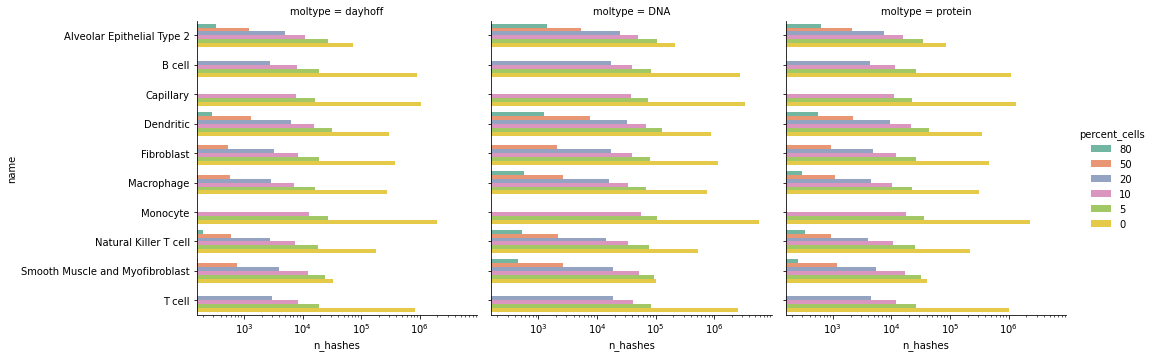

In [123]:
csvs = glob.glob(
    os.path.join(
        train_dir, "2--merged-celltype-sigs--min-kmer-count--*-percent", "*.csv"
    )
)
csvs

dfs = [sig_describe]
for csv in csvs:
    df = pd.read_csv(csv)
    dirname_base = os.path.basename(os.path.dirname(csv))
    percent = int(dirname_base.split("--")[-1].split("-")[0])
    df["percent_cells"] = percent
    dfs.append(df)

sourmash_sig_describe_fractions = pd.concat(dfs)
sourmash_sig_describe_fractions = sourmash_sig_describe_fractions.join(
    group_counts, on="name"
)
sourmash_sig_describe_fractions['n_hashes_log10'] = np.log10(sourmash_sig_describe_fractions.n_hashes)
sourmash_sig_describe_fractions['n_cells_per_celltype_log10'] = np.log10(sourmash_sig_describe_fractions.n_cells_per_celltype)
describe(sourmash_sig_describe_fractions)

g = sns.catplot(
    data=sourmash_sig_describe_fractions,
    hue="percent_cells",
    col="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    hue_order=[80, 50, 20, 10, 5, 0],
    palette="Set2",
)
g.set(xscale="log")

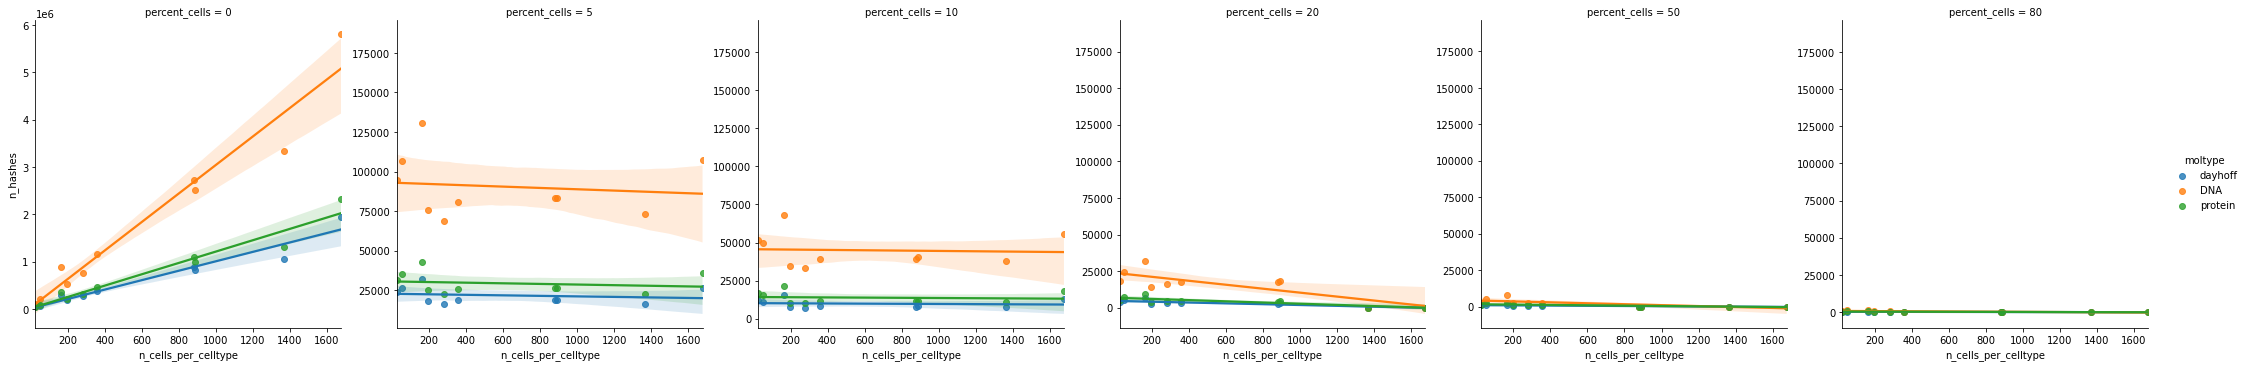

In [125]:
g = sns.lmplot(
    data=sourmash_sig_describe_fractions,
    x="n_cells_per_celltype",
    y="n_hashes",
    hue="moltype",
    fit_reg=True,
    col='percent_cells',
    sharey=False
)

In [137]:
sourmash_sig_describe_fractions.query("moltype == 'dayhoff' and percent_cells == 10")

,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,bc9f55aa8cef9d16167578cc290db004,17,dayhoff,0,10,11069,42,1,Alveolar Epithelial Type 2,** no name **,CC0,10,NaN,51,4.044108,1.707570
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,d3acc9f7fe937ca1a0a98219aea4aa22,17,dayhoff,0,10,7987,42,1,B cell,** no name **,CC0,10,NaN,880,3.902384,2.944483
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,cc801816f988004ba7157278eb066ef0,17,dayhoff,0,10,7714,42,1,Capillary,** no name **,CC0,10,NaN,1365,3.887280,3.135133
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,3049e1aa17ead6f732d397ca0d8c0b86,17,dayhoff,0,10,15484,42,1,Dendritic,** no name **,CC0,10,NaN,164,4.189883,2.214844
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,32c1d9f9e7b5d29f9373627d0d84cda5,17,dayhoff,0,10,8424,42,1,Fibroblast,** no name **,CC0,10,NaN,357,3.925518,2.552668
5,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,ca174a02632aaa0818f3c2c846d6b93c,17,dayhoff,0,10,7115,42,1,Macrophage,** no name **,CC0,10,NaN,280,3.852175,2.447158
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,cb88798b0b17eed87c08ab914bf055e3,17,dayhoff,0,10,12985,42,1,Monocyte,** no name **,CC0,10,NaN,1676,4.113442,3.224274
7,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,fdd04776899125236e48a639963d6dc2,17,dayhoff,0,10,7497,42,1,Natural Killer T cell,** no name **,CC0,10,NaN,196,3.874888,2.292256
8,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,11b23e5113fa5b60d7733044f457bba6,17,dayhoff,0,10,12433,42,1,Smooth Muscle and Myofibroblast,** no name **,CC0,10,NaN,26,4.094576,1.414973
9,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,ff9f93d5d64c535995c1c1072ea5ba5e,17,dayhoff,0,10,8269,42,1,T cell,** no name **,CC0,10,NaN,889,3.917453,2.948902


In [138]:
sourmash_sig_describe_fractions.query("moltype == 'dayhoff' and percent_cells == 5")

,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,b26657347cbff4f522ad3bd1e6fd172a,17,dayhoff,0,10,26676,42,1,Alveolar Epithelial Type 2,** no name **,CC0,5,NaN,51,4.426121,1.707570
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,77949db02296d0579806ba916e387d1e,17,dayhoff,0,10,19104,42,1,B cell,** no name **,CC0,5,NaN,880,4.281124,2.944483
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,7316c1c117177f2bae29dbe0d0086174,17,dayhoff,0,10,16506,42,1,Capillary,** no name **,CC0,5,NaN,1365,4.217642,3.135133
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,edc68bca2a40013c4ac4a98505fda73f,17,dayhoff,0,10,32421,42,1,Dendritic,** no name **,CC0,5,NaN,164,4.510826,2.214844
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,48bb7ac03772a7657e7563ac61b6fcaa,17,dayhoff,0,10,18794,42,1,Fibroblast,** no name **,CC0,5,NaN,357,4.274019,2.552668
5,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,b626db234d44565e6197ae0519fa387f,17,dayhoff,0,10,16057,42,1,Macrophage,** no name **,CC0,5,NaN,280,4.205664,2.447158
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,4f0edaa6e0bf2b397d3a7717f0021f9d,17,dayhoff,0,10,26744,42,1,Monocyte,** no name **,CC0,5,NaN,1676,4.427226,3.224274
7,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,29d0b525e612565e4c956ab5ade8a7f3,17,dayhoff,0,10,18504,42,1,Natural Killer T cell,** no name **,CC0,5,NaN,196,4.267266,2.292256
8,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,019d13ca2978d522eb6a3bd7c0e816b2,17,dayhoff,0,10,24153,42,1,Smooth Muscle and Myofibroblast,** no name **,CC0,5,NaN,26,4.382971,1.414973
9,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,8bdadd01f4d4817ab8fbf0859513fc4b,17,dayhoff,0,10,19117,42,1,T cell,** no name **,CC0,5,NaN,889,4.281420,2.948902


#### @paper `n_cells_per_celltype` vs `n_hashes`, no log, `sharey=False`

In [141]:
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/figures/mouse_celltype_db"
)

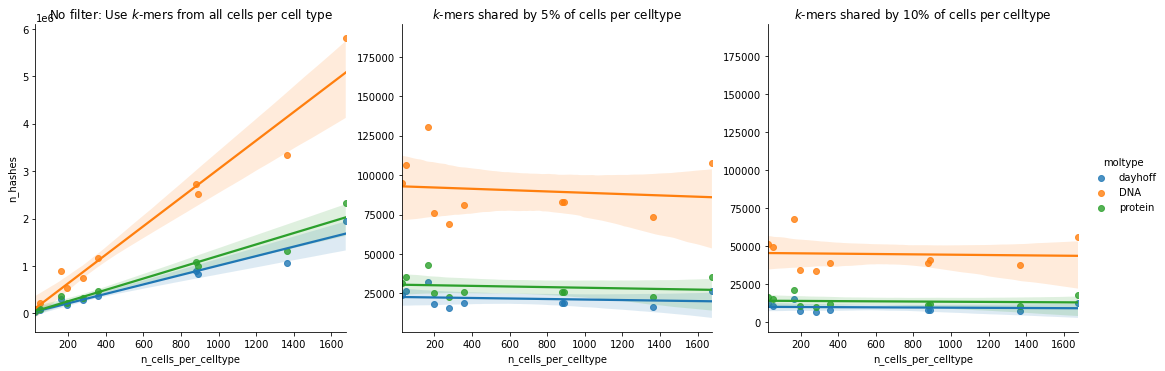

In [143]:
g = sns.lmplot(
    data=sourmash_sig_describe_fractions,
    x="n_cells_per_celltype",
    y="n_hashes",
    hue="moltype",
    fit_reg=True,
    col='percent_cells',
    col_order=[0, 5, 10],
#     logy=True
    sharey=False
)

titles = ['No filter: Use $k$-mers from all cells per cell type', '$k$-mers shared by 5% of cells per celltype', '$k$-mers shared by 10% of cells per celltype']
for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
# g.set(yscale='log')
pdf = os.path.join(
    figure_folder,
    "lmplot__n_kmers_per_celltype__vs__n_hashes__hue-percent_shared_kmers.pdf",
)
g.savefig(pdf)

#### @paper `n_cells_per_celltype` vs `n_hashes`: `yscale=log`, `sharey=True`

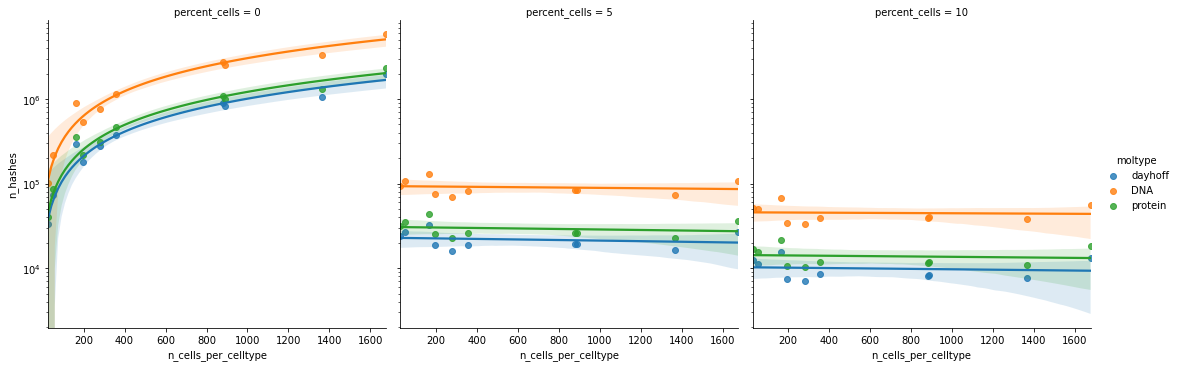

In [140]:
g = sns.lmplot(
    data=sourmash_sig_describe_fractions,
    x="n_cells_per_celltype",
    y="n_hashes",
    hue="moltype",
    fit_reg=True,
    col='percent_cells',
    col_order=[0, 5, 10],
#     logy=True
#     sharey=False
)
g.set(yscale='log')

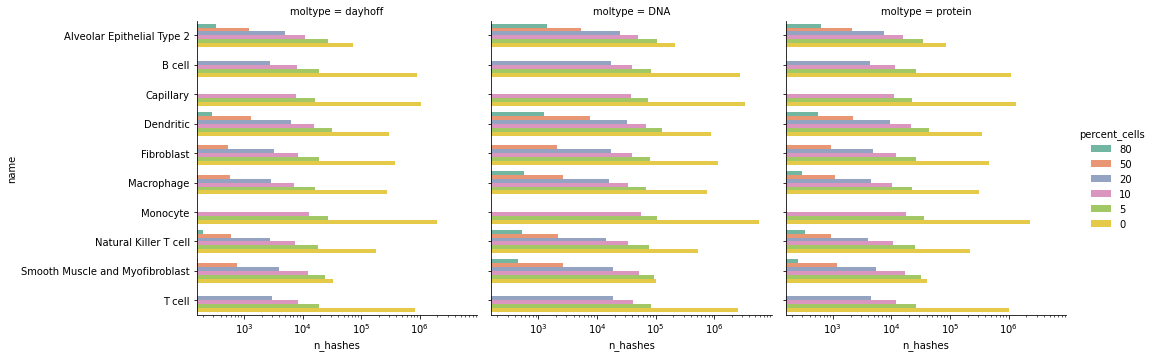

In [126]:
g = sns.catplot(
    data=sourmash_sig_describe_fractions,
    hue="percent_cells",
    col="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    hue_order=[80, 50, 20, 10, 5, 0],
    palette="Set2",
)
g.set(xscale="log")

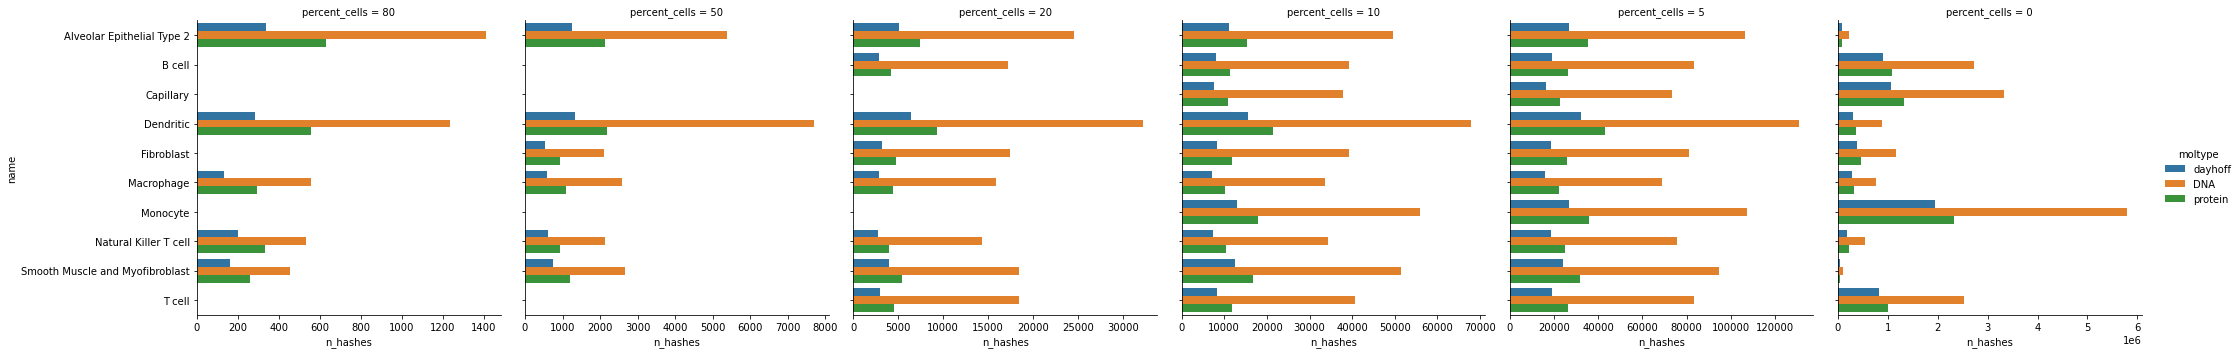

In [145]:
g = sns.catplot(
    data=sourmash_sig_describe_fractions,
    col="percent_cells",
    hue="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    col_order=[80, 50, 20, 10, 5, 0],
    sharex=False
)
pdf = os.path.join(
    figure_folder,
    "barplot__n_kmers_per_celltype__hue-moltype__col-percent_cells_sharing_kmers.pdf",
)
g.savefig(pdf)

In [79]:
group_counts

broad_group
Smooth Muscle and Myofibroblast      26
Alveolar Epithelial Type 2           51
Dendritic                           164
Natural Killer T cell               196
Macrophage                          280
Fibroblast                          357
B cell                              880
T cell                              889
Capillary                          1365
Monocyte                           1676
dtype: int64

### Try integer thresholds

In [55]:
thresholds = 2, 5, 10

for threshold in thresholds:
    threshold_outdir = f'{train_2_merged_celltype_min_kmer_count}--{threshold}-n-cells'
    ! mkdir $threshold_outdir
    print(threshold_outdir)
    Parallel(n_jobs=96)(
        delayed(sig_utils.merge_celltype_sigs)(
            sketch_id,
            ksize,
            moltype,
            broad_group,
            df,
            merged_celltype_outdir_base=threshold_outdir,
            dryrun=False,
            force=True,
            min_sig_fraction=threshold,
        )
        for (sketch_id, moltype, ksize, broad_group), df in tqdm(
            grouped, total=len(grouped)
        )
    )
    ! sourmash sig describe \
        --csv $threshold_outdir/sourmash_sig_describe.csv \
        $threshold_outdir/*/*.sig

100%|██████████| 30/30 [00:00<00:00, 804.34it/s]

/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--2-n-cells



== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--2-n-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: 80e3ab7d4edbbdfb658d2ff1c9cc4bae
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 45854
signature license: CC0

<<<-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
---<<<-min-kmer-count--2-n-cells/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--2-n-cells/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig
signature: B cell
source

100%|██████████| 30/30 [00:00<00:00, 788.81it/s]

/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--5-n-cells



== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--5-n-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: 8b7769fd4e3dc5fa7605e8808834ee16
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 13979
signature license: CC0

<<<-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
---<<<-min-kmer-count--5-n-cells/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--5-n-cells/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig
signature: B cell
source

100%|██████████| 30/30 [00:00<00:00, 797.17it/s]

/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--10-n-cells



== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--10-n-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: 4a300f4c69b968079f5d8024da3488b3
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 5758
signature license: CC0

<<<-cells/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
---<<<min-kmer-count--10-n-cells/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/2--merged-celltype-sigs--min-kmer-count--10-n-cells/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig
signature: B cell
sourc

#### Plot sourmash sig describe

(120, 14)
--- First 5 entries ---


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0,100.0,all
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0,100.0,all
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0,100.0,all
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0,100.0,all
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0,100.0,all


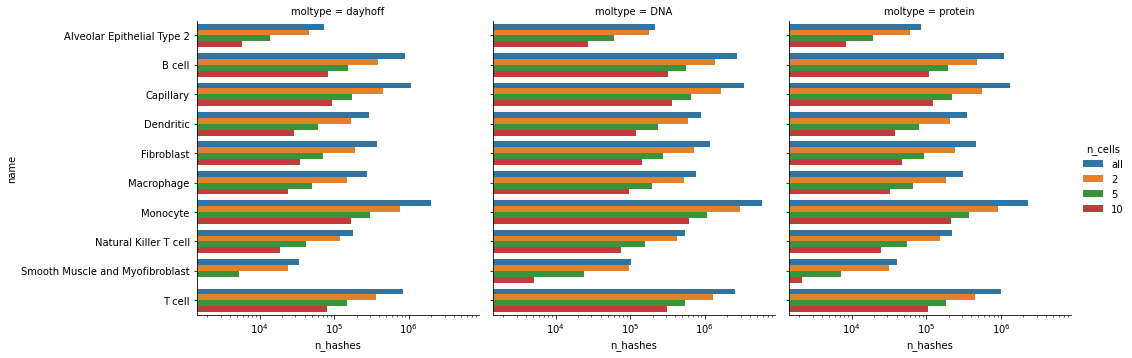

In [95]:
csvs = glob.glob(
    os.path.join(train_dir, "2--merged-celltype-sigs--min-kmer-count--*-n-cells/*.csv")
)
csvs

dfs = [sig_describe]
for csv in csvs:
    df = pd.read_csv(csv)
    dirname_base = os.path.basename(os.path.dirname(csv))
    n_cells = int(dirname_base.split("--")[-1].split("-")[0])
    df["n_cells"] = n_cells
    dfs.append(df)
sourmash_sig_describe_n_cells = pd.concat(dfs)

sourmash_sig_describe_n_cells = sourmash_sig_describe_n_cells.join(
    group_counts, on="name"
)
sourmash_sig_describe_n_cells['n_hashes_log10'] = np.log10(sourmash_sig_describe_n_cells.n_hashes)
sourmash_sig_describe_n_cells['n_cells_per_celltype_log10'] = np.log10(sourmash_sig_describe_n_cells.n_cells_per_celltype)

describe(sourmash_sig_describe_n_cells)

g = sns.catplot(
    data=sourmash_sig_describe_n_cells,
    hue="n_cells",
    col="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    hue_order=['all', 2, 5, 10]
)
g.set(xscale='log')

In [119]:
sourmash_sig_describe_n_cells.query('name == "Monocyte" and moltype == "dayhoff"')

,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10,threshold
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,28f39e7e998714f06baeedb4de012980,17,dayhoff,0,10,1952604,42,1,Monocyte,** no name **,CC0,0.0,all,1676,6.290614,3.224274,n_cells
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,9e050d8e55e0dd227f2dba9dd87390e0,17,dayhoff,0,10,167341,42,1,Monocyte,** no name **,CC0,NaN,10,1676,5.223602,3.224274,n_cells
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,7b201d0da764c50a59f90a27a21d1a1d,17,dayhoff,0,10,756434,42,1,Monocyte,** no name **,CC0,NaN,2,1676,5.878771,3.224274,n_cells
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,21d4d026813cdd72d06e34fb6b820c11,17,dayhoff,0,10,300353,42,1,Monocyte,** no name **,CC0,NaN,5,1676,5.477632,3.224274,n_cells


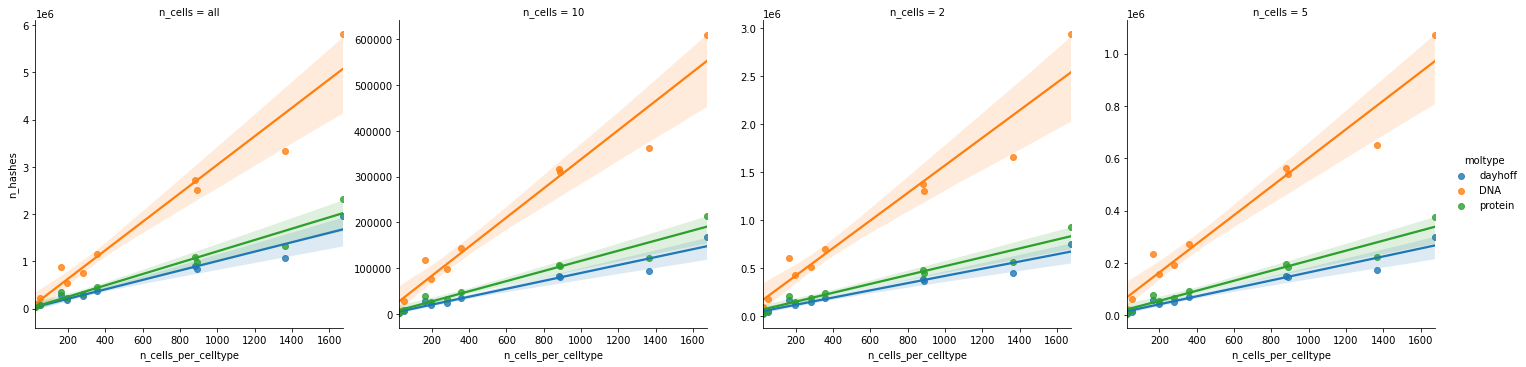

In [99]:
g = sns.lmplot(
    data=sourmash_sig_describe_n_cells,
    x="n_cells_per_celltype",
    y="n_hashes",
    col='n_cells',
    hue="moltype",
    fit_reg=True,
        sharey=False
)

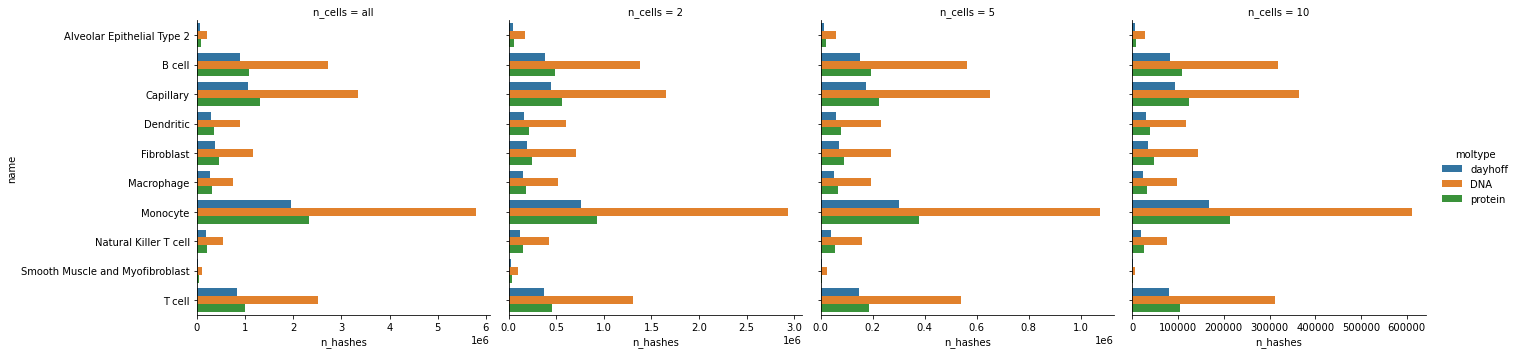

In [64]:
g = sns.catplot(
    data=sourmash_sig_describe,
    col="n_cells",
    hue="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    col_order=['all', 2, 5, 10],
    sharex=False
)
# g.set(xscale='log')

### Combine `sourmash sig describe` from both n_cells and fractional

In [111]:
sourmash_sig_describe_n_cells["threshold"] = "n_cells"
sourmash_sig_describe_fractions["threshold"] = "percentage"

sourmash_sig_describe_combined = pd.concat(
    [sourmash_sig_describe_fractions, sourmash_sig_describe_n_cells], ignore_index=False
)
sourmash_sig_describe_combined[
    "threshold_value"
] = sourmash_sig_describe_combined.apply(
    lambda x: x["threshold"] + ": " + str(int(x["percent_cells"]))
    if x["threshold"] == "percentage"
    else x["threshold"] + ": " + str(x["n_cells"]),
    axis=1,
)
describe(sourmash_sig_describe_combined)


(240, 19)
--- First 5 entries ---


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10,threshold,threshold_value
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0,0.0,all,51,4.866783,1.707570,percentage,percentage: 0
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0,0.0,all,880,5.953144,2.944483,percentage,percentage: 0
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0,0.0,all,1365,6.028143,3.135133,percentage,percentage: 0
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0,0.0,all,164,5.471119,2.214844,percentage,percentage: 0
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0,0.0,all,357,5.574453,2.552668,percentage,percentage: 0


In [112]:
sourmash_sig_describe_combined.threshold_value.unique()

array(['percentage: 0', 'percentage: 20', 'percentage: 80',
       'percentage: 50', 'n_cells: all', 'n_cells: 10', 'n_cells: 2',
       'n_cells: 5'], dtype=object)

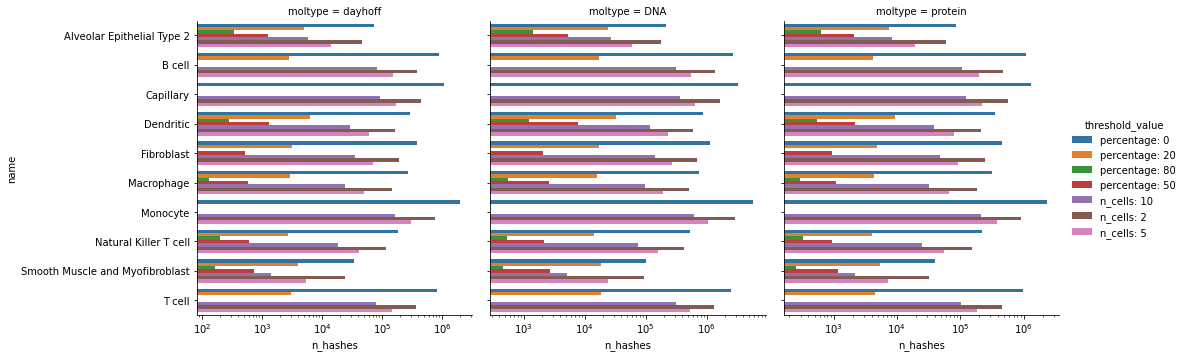

In [117]:


g = sns.catplot(
    data=sourmash_sig_describe_combined,
    col="moltype",
    hue="threshold_value",
    x="n_hashes",
    y="name",
    kind="bar",
    hue_order=['percentage: 0', 'percentage: 20', 'percentage: 80',
       'percentage: 50',  'n_cells: 10', 'n_cells: 2',
       'n_cells: 5'],
    sharex=False
)
g.set(xscale='log')

# Remove k-mers shared across cell types

## Remove hashes present across 80% of celltypes

In [146]:
per_celltype_sigs_df.dtypes

sketch_id      object
alphabet       object
ksize           int64
broad_group    object
sig_path       object
dtype: object

In [147]:
train_3_merged_celltype_remove_common

'/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers'

In [148]:
ls -lha $train_dir

total 8.5K
drwxr-xr-x 17 olga czb 4.0K Mar 26 19:33 ./
drwxr-xr-x  7 olga czb 4.0K Mar  5 12:02 ../
drwxr-xr-x  4 olga czb 4.0K Feb 28 10:19 0--protein-coding-fastas/
drwxr-xr-x  5 olga czb 4.0K Feb 28 09:34 1--single-cell-sigs/
drwxr-xr-x  5 olga czb 4.0K Feb 28 10:58 2--merged-celltype-sigs/
drwxr-xr-x  5 olga czb 4.0K Mar 26 16:23 2--merged-celltype-sigs--min-kmer-count/
drwxr-xr-x  5 olga czb 4.0K Mar 26 19:08 2--merged-celltype-sigs--min-kmer-count--10-n-cells/
drwxr-xr-x  5 olga czb 4.0K Mar 26 19:35 2--merged-celltype-sigs--min-kmer-count--10-percent/
drwxr-xr-x  5 olga czb 4.0K Mar 26 18:50 2--merged-celltype-sigs--min-kmer-count--20-percent/
drwxr-xr-x  5 olga czb 4.0K Mar 26 19:04 2--merged-celltype-sigs--min-kmer-count--2-n-cells/
drwxr-xr-x  5 olga czb 4.0K Mar 26 18:52 2--merged-celltype-sigs--min-kmer-count--50-percent/
drwxr-xr-x  5 olga czb 4.0K Mar 26 19:06 2--merged-celltype-sigs--min-kmer-count--5-n-cells/
drwxr-xr-x  5 olga czb 4.0K Mar 26 19:33 2--merged-celltype-s

In [156]:
sketch_id_to_broad_group = train_sig_df_celltypes.groupby(
    ["sketch_id", "alphabet", "ksize", 'broad_group'], observed=True
).size()
sketch_id_to_broad_group.name = 'n_cells'
sketch_id_to_broad_group = sketch_id_to_broad_group.reset_index()
sketch_id_to_broad_group['sanitized'] = sketch_id_to_broad_group.broad_group.map(sig_utils.sanitize)
describe(sketch_id_to_broad_group)


(30, 6)
--- First 5 entries ---


,sketch_id,alphabet,ksize,broad_group,n_cells,sanitized
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,B cell,880,b_cell
1,alphabet-DNA__ksize-21__scaled-10,DNA,21,Monocyte,1676,monocyte
2,alphabet-DNA__ksize-21__scaled-10,DNA,21,Macrophage,280,macrophage
3,alphabet-DNA__ksize-21__scaled-10,DNA,21,T cell,889,t_cell
4,alphabet-DNA__ksize-21__scaled-10,DNA,21,Capillary,1365,capillary


### Sourmash sig describe on remove common k-mer

In [163]:
thresholds = 0.05, 0.1

for threshold in thresholds:
    threshold_indir_base = (
        f"{train_2_merged_celltype_min_kmer_count}--{int(threshold*100):d}-percent"
    )
    threshold_outdir = f"{train_3_merged_celltype_remove_common}--min-kmer-count--{int(threshold*100):d}-percent"

    sketch_id_to_broad_group["sig_path"] = sketch_id_to_broad_group.apply(
        lambda x: os.path.join(
            threshold_indir_base, x["sketch_id"], x["sanitized"] + ".sig"
        ),
        axis=1,
    )
    describe(sketch_id_to_broad_group)
    grouped = sketch_id_to_broad_group.groupby(['sketch_id', 'alphabet', 'ksize'])
    print(threshold_outdir)
    sigs_without_common_hashes = Parallel(n_jobs=64)(
        delayed(sig_utils.remove_common_hashes_from_sig_df)(
            df,
            sketch_id,
            ksize,
            moltype,
            fraction_threshold=0.8,
            output_dir=threshold_outdir,
            force=True,
            #         create_hash_count_csv=False,
        )
        for (sketch_id, moltype, ksize), df in tqdm(grouped, total=len(grouped))
    )
    ! sourmash sig describe \
        --csv $threshold_outdir/sourmash_sig_describe.csv \
        $threshold_outdir/*/*.sig

(30, 7)
--- First 5 entries ---


,sketch_id,alphabet,ksize,broad_group,n_cells,sanitized,sig_path
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,B cell,880,b_cell,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
1,alphabet-DNA__ksize-21__scaled-10,DNA,21,Monocyte,1676,monocyte,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
2,alphabet-DNA__ksize-21__scaled-10,DNA,21,Macrophage,280,macrophage,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
3,alphabet-DNA__ksize-21__scaled-10,DNA,21,T cell,889,t_cell,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
4,alphabet-DNA__ksize-21__scaled-10,DNA,21,Capillary,1365,capillary,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...


100%|██████████| 3/3 [00:00<00:00, 485.70it/s]

/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers--min-kmer-count--5-percent



== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers--min-kmer-count--5-percent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: bb53fcbe282d7c24c062fc7690bca8f9
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 18149
signature license: CC0

<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
---<<<-min-kmer-count--5-percent/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers--min-kmer-count--5-percent/alphabet-dayhoff__ksize-51__scaled-10/b_cel

,sketch_id,alphabet,ksize,broad_group,n_cells,sanitized,sig_path
0,alphabet-DNA__ksize-21__scaled-10,DNA,21,B cell,880,b_cell,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
1,alphabet-DNA__ksize-21__scaled-10,DNA,21,Monocyte,1676,monocyte,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
2,alphabet-DNA__ksize-21__scaled-10,DNA,21,Macrophage,280,macrophage,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
3,alphabet-DNA__ksize-21__scaled-10,DNA,21,T cell,889,t_cell,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...
4,alphabet-DNA__ksize-21__scaled-10,DNA,21,Capillary,1365,capillary,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...


/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers--min-kmer-count--10-percent


100%|██████████| 3/3 [00:00<00:00, 824.41it/s]



== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers--min-kmer-count--10-percent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: 1e4f985febd6034d765e83b34a1fa5f0
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 7289
signature license: CC0

<<<ercent/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig'
---<<<min-kmer-count--10-percent/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig'
signature filename: /home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers--min-kmer-count--10-percent/alphabet-dayhoff__ksize-51__scaled-10/b_ce

#### Plot sourmash sig describe

In [169]:
# sig_describe

In [176]:
csvs = glob.glob(
    os.path.join(
        train_dir, "3--merged-celltype-remove-common-kmers--min-kmer-count--*-percent",  "*.csv"
    )
)
print(f"len(csvs): {len(csvs)}")

len(csvs): 2


(90, 17)
--- First 5 entries ---


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0,0,all,51,4.866783,1.707570
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0,0,all,880,5.953144,2.944483
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0,0,all,1365,6.028143,3.135133
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0,0,all,164,5.471119,2.214844
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0,0,all,357,5.574453,2.552668


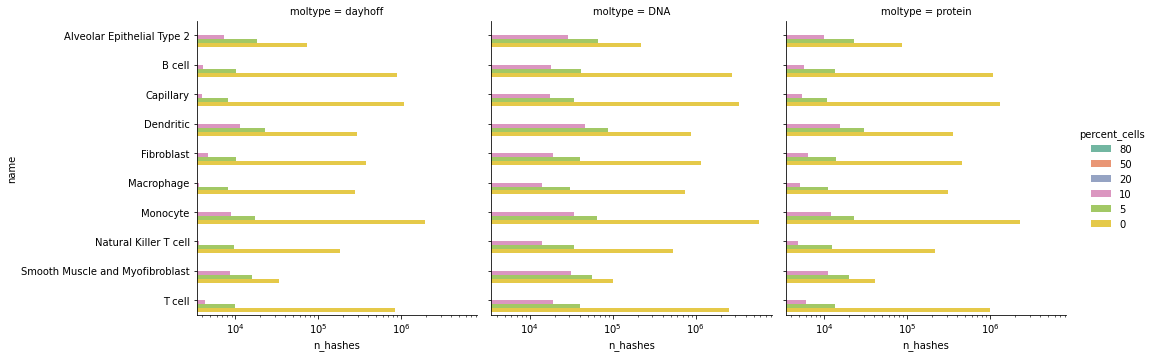

In [177]:
dfs = [sig_describe]
for csv in csvs:
    df = pd.read_csv(csv)
    dirname_base = os.path.basename(os.path.dirname(csv))
    percent = int(dirname_base.split("--")[-1].split("-")[0])
    df["percent_cells"] = percent
    dfs.append(df)

sourmash_sig_describe_fractions_remove_common = pd.concat(dfs)
sourmash_sig_describe_fractions_remove_common = sourmash_sig_describe_fractions_remove_common.join(
    group_counts, on="name"
)
sourmash_sig_describe_fractions_remove_common['n_hashes_log10'] = np.log10(sourmash_sig_describe_fractions_remove_common.n_hashes)
sourmash_sig_describe_fractions_remove_common['n_cells_per_celltype_log10'] = np.log10(sourmash_sig_describe_fractions_remove_common.n_cells_per_celltype)
describe(sourmash_sig_describe_fractions_remove_common)

g = sns.catplot(
    data=sourmash_sig_describe_fractions_remove_common,
    hue="percent_cells",
    col="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    hue_order=[80, 50, 20, 10, 5, 0],
    palette="Set2",
)
g.set(xscale="log")

In [179]:
csv

'/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers--min-kmer-count--10-percent/sourmash_sig_describe.csv'

In [180]:
percent

10

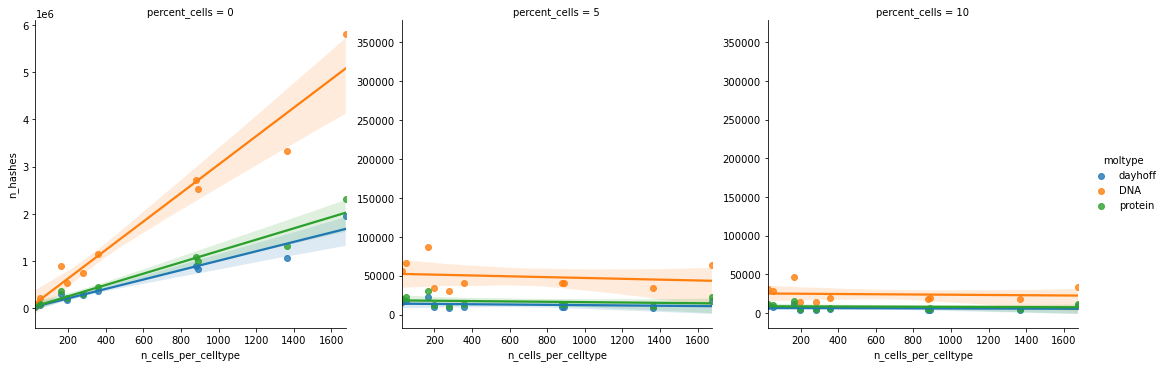

In [181]:
g = sns.lmplot(
    data=sourmash_sig_describe_fractions_remove_common,
    x="n_cells_per_celltype",
    y="n_hashes",
    hue="moltype",
    fit_reg=True,
    col='percent_cells',
    sharey=False
)

In [137]:
sourmash_sig_describe_fractions.query("moltype == 'dayhoff' and percent_cells == 10")

,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,bc9f55aa8cef9d16167578cc290db004,17,dayhoff,0,10,11069,42,1,Alveolar Epithelial Type 2,** no name **,CC0,10,NaN,51,4.044108,1.707570
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,d3acc9f7fe937ca1a0a98219aea4aa22,17,dayhoff,0,10,7987,42,1,B cell,** no name **,CC0,10,NaN,880,3.902384,2.944483
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,cc801816f988004ba7157278eb066ef0,17,dayhoff,0,10,7714,42,1,Capillary,** no name **,CC0,10,NaN,1365,3.887280,3.135133
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,3049e1aa17ead6f732d397ca0d8c0b86,17,dayhoff,0,10,15484,42,1,Dendritic,** no name **,CC0,10,NaN,164,4.189883,2.214844
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,32c1d9f9e7b5d29f9373627d0d84cda5,17,dayhoff,0,10,8424,42,1,Fibroblast,** no name **,CC0,10,NaN,357,3.925518,2.552668
5,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,ca174a02632aaa0818f3c2c846d6b93c,17,dayhoff,0,10,7115,42,1,Macrophage,** no name **,CC0,10,NaN,280,3.852175,2.447158
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,cb88798b0b17eed87c08ab914bf055e3,17,dayhoff,0,10,12985,42,1,Monocyte,** no name **,CC0,10,NaN,1676,4.113442,3.224274
7,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,fdd04776899125236e48a639963d6dc2,17,dayhoff,0,10,7497,42,1,Natural Killer T cell,** no name **,CC0,10,NaN,196,3.874888,2.292256
8,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,11b23e5113fa5b60d7733044f457bba6,17,dayhoff,0,10,12433,42,1,Smooth Muscle and Myofibroblast,** no name **,CC0,10,NaN,26,4.094576,1.414973
9,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,ff9f93d5d64c535995c1c1072ea5ba5e,17,dayhoff,0,10,8269,42,1,T cell,** no name **,CC0,10,NaN,889,3.917453,2.948902


In [138]:
sourmash_sig_describe_fractions.query("moltype == 'dayhoff' and percent_cells == 5")

,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,percent_cells,n_cells,n_cells_per_celltype,n_hashes_log10,n_cells_per_celltype_log10
0,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,b26657347cbff4f522ad3bd1e6fd172a,17,dayhoff,0,10,26676,42,1,Alveolar Epithelial Type 2,** no name **,CC0,5,NaN,51,4.426121,1.707570
1,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,77949db02296d0579806ba916e387d1e,17,dayhoff,0,10,19104,42,1,B cell,** no name **,CC0,5,NaN,880,4.281124,2.944483
2,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,7316c1c117177f2bae29dbe0d0086174,17,dayhoff,0,10,16506,42,1,Capillary,** no name **,CC0,5,NaN,1365,4.217642,3.135133
3,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,edc68bca2a40013c4ac4a98505fda73f,17,dayhoff,0,10,32421,42,1,Dendritic,** no name **,CC0,5,NaN,164,4.510826,2.214844
4,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,48bb7ac03772a7657e7563ac61b6fcaa,17,dayhoff,0,10,18794,42,1,Fibroblast,** no name **,CC0,5,NaN,357,4.274019,2.552668
5,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,b626db234d44565e6197ae0519fa387f,17,dayhoff,0,10,16057,42,1,Macrophage,** no name **,CC0,5,NaN,280,4.205664,2.447158
6,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,4f0edaa6e0bf2b397d3a7717f0021f9d,17,dayhoff,0,10,26744,42,1,Monocyte,** no name **,CC0,5,NaN,1676,4.427226,3.224274
7,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,29d0b525e612565e4c956ab5ade8a7f3,17,dayhoff,0,10,18504,42,1,Natural Killer T cell,** no name **,CC0,5,NaN,196,4.267266,2.292256
8,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,019d13ca2978d522eb6a3bd7c0e816b2,17,dayhoff,0,10,24153,42,1,Smooth Muscle and Myofibroblast,** no name **,CC0,5,NaN,26,4.382971,1.414973
9,/home/olga/data_lg/data_sm_copy/immune-evolution/kmer-signa...,8bdadd01f4d4817ab8fbf0859513fc4b,17,dayhoff,0,10,19117,42,1,T cell,** no name **,CC0,5,NaN,889,4.281420,2.948902


#### @paper `n_cells_per_celltype` vs `n_hashes`, no log, `sharey=False`

In [141]:
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/figures/mouse_celltype_db"
)

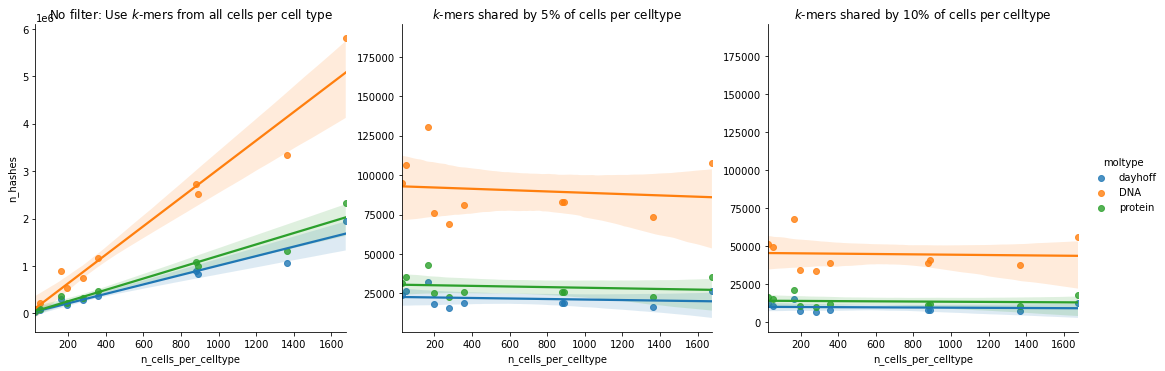

In [143]:
g = sns.lmplot(
    data=sourmash_sig_describe_fractions,
    x="n_cells_per_celltype",
    y="n_hashes",
    hue="moltype",
    fit_reg=True,
    col='percent_cells',
    col_order=[0, 5, 10],
#     logy=True
    sharey=False
)

titles = ['No filter: Use $k$-mers from all cells per cell type', '$k$-mers shared by 5% of cells per celltype', '$k$-mers shared by 10% of cells per celltype']
for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
# g.set(yscale='log')
pdf = os.path.join(
    figure_folder,
    "lmplot__n_kmers_per_celltype__vs__n_hashes__hue-percent_shared_kmers.pdf",
)
g.savefig(pdf)

In [85]:
%%time

grouped = per_celltype_sigs_df.groupby(["sketch_id", "alphabet", "ksize"])


sigs_without_common_hashes = Parallel(n_jobs=64)(
    delayed(sig_utils.remove_common_hashes_from_sig_df)(
        df,
        sketch_id,
        ksize,
        moltype,
        fraction_threshold=0.8,
        output_dir=train_3_merged_celltype_remove_common,
        force=True,
#         create_hash_count_csv=False,
    )
    for (sketch_id, moltype, ksize), df in tqdm(grouped, total=len(grouped))
)
len(sigs_without_common_hashes)


100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


CPU times: user 32.5 s, sys: 6.29 s, total: 38.8 s
Wall time: 5h 35min 33s


3